In [ ]:

## should be same as AudiosetProcessing
pos = "female" #laughter
neg =  "not_" + pos
dataset_name  = pos + "_" + neg 
evalset_name  = 'eval_' + dataset_name + '_training_subset.csv'
trainset_name = dataset_name + '_training_subset.csv'
bal_name = 'bal_' + dataset_name + '.tfrecord'
##
data_labels = [2,33] #for female.  #laugh_labels = [16, 17, 18, 19, 20, 21]

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
import numpy as np
import tensorflow as tf
import keras
import pandas as pd
from keras_tqdm import TQDMNotebookCallback


Using TensorFlow backend.


In [2]:
from keras.preprocessing.sequence import pad_sequences

def data_generator(batch_size, tfrecord, start_frac=0, end_frac=1):
    '''
    Shuffles the Audioset training data and returns a generator of training data and boolean laughter labels
    batch_size: batch size for each set of training data and labels
    tfrecord: filestring of the tfrecord file to train on
    start_frac: the starting point of the data set to use, as a fraction of total record length (used for CV)
    end_frac: the ending point of the data set to use, as a fraction of total record length (used for CV)
    '''
    max_len=10
    records = list(tf.python_io.tf_record_iterator(tfrecord))
    records = records[int(start_frac*len(records)):int(end_frac*len(records))]
    rec_len = len(records)
    shuffle = np.random.permutation(range(rec_len))
    num_batches = rec_len//batch_size - 1
    j = 0

    
    while True:
        X = []
        y = []
        for idx in shuffle[j*batch_size:(j+1)*batch_size]:
            example = records[idx]
            tf_seq_example = tf.train.SequenceExample.FromString(example)
            example_label = list(np.asarray(tf_seq_example.context.feature['labels'].int64_list.value))
                        
            data_bin = any((True for x in example_label if x in data_labels)) 
            y.append(data_bin)

            n_frames = len(tf_seq_example.feature_lists.feature_list['audio_embedding'].feature)
            audio_frame = []
            for i in range(n_frames):
                audio_frame.append(np.frombuffer(tf_seq_example.feature_lists.feature_list['audio_embedding'].
                                                         feature[i].bytes_list.value[0],np.uint8).astype(np.float32))
            pad = [np.zeros([128], np.float32) for i in range(max_len-n_frames)]
            audio_frame += pad
            X.append(audio_frame)

        j += 1
        if j >= num_batches:
            shuffle = np.random.permutation(range(rec_len))
            j = 0

        X = np.array(X)
        yield X, np.array(y)

### Logistic Regression

In [3]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Flatten

lr_model = Sequential()
# lr_model.add(keras.Input((None, 128)))
lr_model.add(BatchNormalization(input_shape=(10, 128)))
lr_model.add(Flatten())
lr_model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
lr_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
batch_size=32

CV_frac = 0.1
train_gen = data_generator(batch_size,'../Data/bal_laugh_speech_subset.tfrecord', 0, 1-CV_frac)
val_gen = data_generator(128,'../Data/bal_laugh_speech_subset.tfrecord', 1-CV_frac, 1)

rec_len = 18768

lr_h = lr_model.fit_generator(train_gen,steps_per_epoch=int(rec_len*(1-CV_frac))//batch_size, epochs=100, 
                       validation_data=val_gen, validation_steps=int(rec_len*CV_frac)//128,
                       verbose=0, callbacks=[TQDMNotebookCallback()])

Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


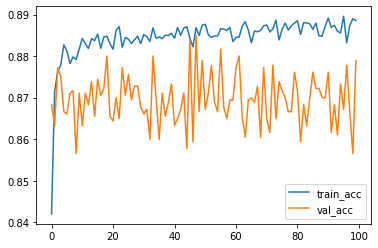

In [5]:
plt.plot(lr_h.history['acc'], label='train_acc')
plt.plot(lr_h.history['val_acc'], label='val_acc')
plt.legend()

In [6]:
lr_model.save('../Models/LogisticRegression_100Epochs.h5')

### Single Layer LSTM

In [7]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.layers import LSTM
from keras import regularizers

lstm_model = Sequential()
lstm_model.add(BatchNormalization(input_shape=(None, 128)))
lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(128, activation='relu',
        kernel_regularizer=regularizers.l2(0.01),
        activity_regularizer=regularizers.l2(0.01)))
lstm_model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
lstm_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
batch_size=32

CV_frac = 0.1
train_gen = data_generator(batch_size,'../Data/bal_laugh_speech_subset.tfrecord', 0, 1-CV_frac)
val_gen = data_generator(128,'../Data/bal_laugh_speech_subset.tfrecord', 1-CV_frac, 1)

rec_len = 18768

lstm_h = lstm_model.fit_generator(train_gen,steps_per_epoch=int(rec_len*(1-CV_frac))//batch_size, epochs=100, 
                       validation_data=val_gen, validation_steps=int(rec_len*CV_frac)//128,
                       verbose=0, callbacks=[TQDMNotebookCallback()])

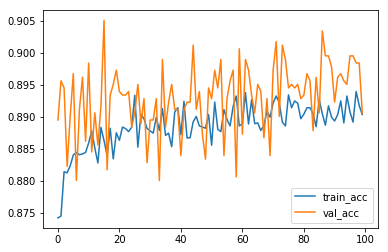

In [8]:
plt.plot(lstm_h.history['acc'], label='train_acc')
plt.plot(lstm_h.history['val_acc'], label='val_acc')
plt.legend()

In [9]:
lstm_model.save('../Models/LSTM_SingleLayer_100Epochs.h5')

### 3 Layer LSTM

In [10]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.layers import LSTM
from keras import regularizers

lstm3_model = Sequential()
lstm3_model.add(BatchNormalization(input_shape=(None, 128)))
lstm3_model.add(Dropout(0.5))

lstm3_model.add(LSTM(64, activation='relu',
        kernel_regularizer=regularizers.l2(0.01),
        activity_regularizer=regularizers.l2(0.01),
        return_sequences=True))

lstm3_model.add(BatchNormalization())
lstm3_model.add(Dropout(0.5))

lstm3_model.add(LSTM(64, activation='relu',
        kernel_regularizer=regularizers.l2(0.01),
        activity_regularizer=regularizers.l2(0.01),
        return_sequences=True))

lstm3_model.add(BatchNormalization())
lstm3_model.add(Dropout(0.5))

lstm3_model.add(LSTM(64, activation='relu',
        kernel_regularizer=regularizers.l2(0.01),
        activity_regularizer=regularizers.l2(0.01)))

lstm3_model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
lstm3_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [11]:
batch_size=32

CV_frac = 0.1
train_gen = data_generator(batch_size,'../Data/bal_laugh_speech_subset.tfrecord', 0, 1-CV_frac)
val_gen = data_generator(128,'../Data/bal_laugh_speech_subset.tfrecord', 1-CV_frac, 1)

rec_len = 18768

lstm3_h = lstm3_model.fit_generator(train_gen,steps_per_epoch=int(rec_len*(1-CV_frac))//batch_size, epochs=100, 
                       validation_data=val_gen, validation_steps=int(rec_len*CV_frac)//128,
                       verbose=0, callbacks=[TQDMNotebookCallback()])

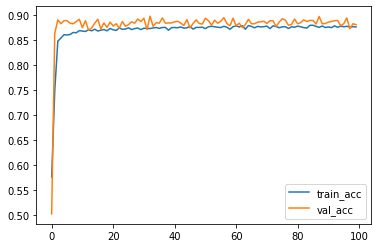

In [13]:
plt.plot(lstm3_h.history['acc'], label='train_acc')
plt.plot(lstm3_h.history['val_acc'], label='val_acc')
plt.legend()

In [14]:
lstm3_model.save('../Models/LSTM_ThreeLayer_100Epochs.h5')

In [15]:
keras.__version__

'2.2.4'